In [0]:
# Refresh input modules when they change
%load_ext autoreload
%autoreload 2

In [0]:
# Import Python packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from datetime import timedelta
from matplotlib.dates import DateFormatter

import sklearn.metrics
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import mlflow
mlflow.sklearn.autolog(disable=True)
mlflow.statsmodels.autolog(disable=True)
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.graphics.api as smg
from scipy import stats

# Import setup file
from base_include import *
from get_model_data import *
from modelling_functions import *

## Modelling
Retrain all the models using all data.

In [0]:
# Set up a dictionary for all four models (grass, grass fdi, forest, forest fdi)
grass_incidents['is_train_data'] = 1
forest_incidents['is_train_data'] = 1
grass_2_hrs_transform_features = ['ruggedness_average_3km', 'building_density_3km', 'road_density_km_in_3km', 'road_distance_m', 'shrub_density_3km', 'soil_moisture']
forest_4_hrs_transform_features = ['road_density_km_in_3km', 'road_distance_m', 'noveg_density_3km', 'distance_to_interface']

models = {
    'grass': {
        'incidents':grass_incidents,
        'outcome':'uncontrolled_within_2_hrs',
        'model_features':grass_2_hrs_features,
        'transform_features': grass_2_hrs_transform_features,
        'transforms':{key: 'np.log1p' for key in grass_2_hrs_transform_features},
    },
    'grass_fdi': {
        'incidents':grass_incidents.dropna(subset='GFDI'),
        'outcome':'uncontrolled_within_2_hrs',
        'model_features':['GFDI'],
        'transforms':{},
    },
    'forest': {
        'incidents':forest_incidents,
        'outcome':'uncontrolled_within_4_hrs',
        'model_features':forest_4_hrs_features,
        'transform_features': forest_4_hrs_transform_features,
        'transforms':{key: 'np.log1p' for key in forest_4_hrs_transform_features},
    },
    'forest_fdi': {
        'incidents':forest_incidents,
        'outcome':'uncontrolled_within_4_hrs',
        'model_features':['FFDI'],
        'transforms':{},
    },
}




Model grass 
Fraction of data used in training: 1.0
Num rows in train:  7580 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.325638
         Iterations 7


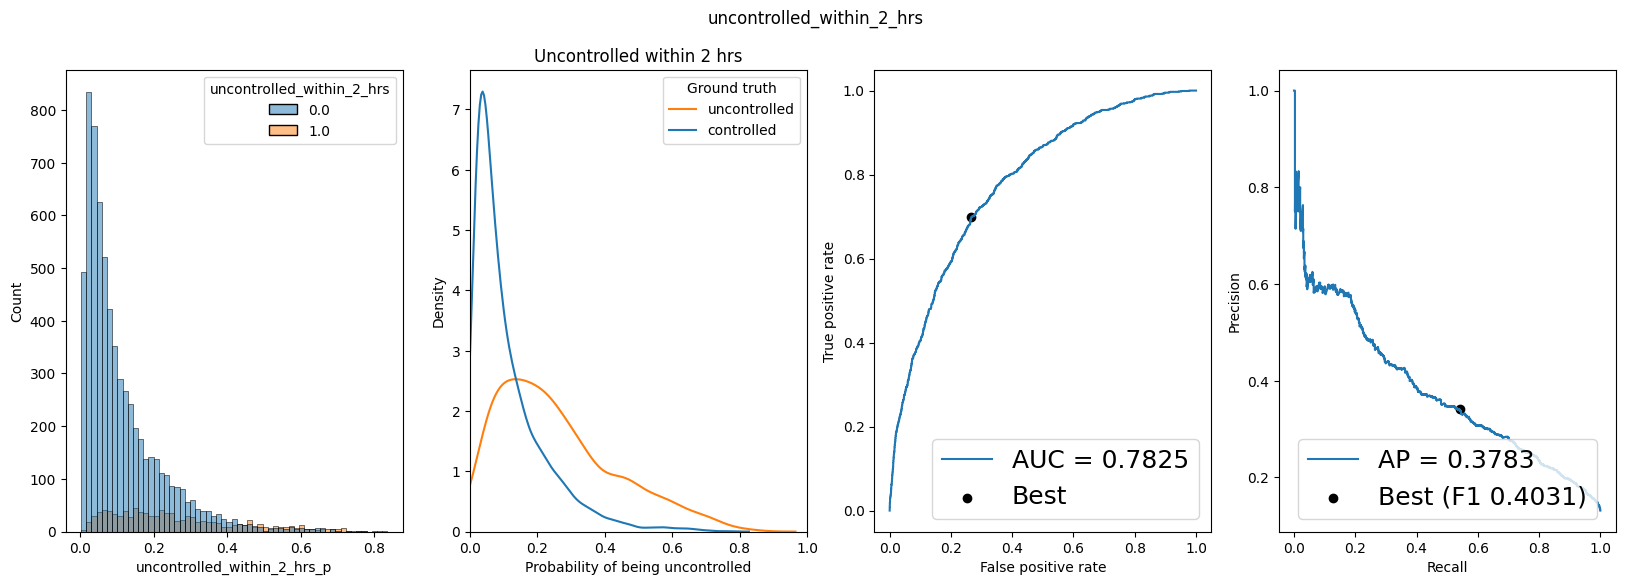

Model grass_fdi 
Fraction of data used in training: 1.0
Num rows in train:  7549 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.378233
         Iterations 6


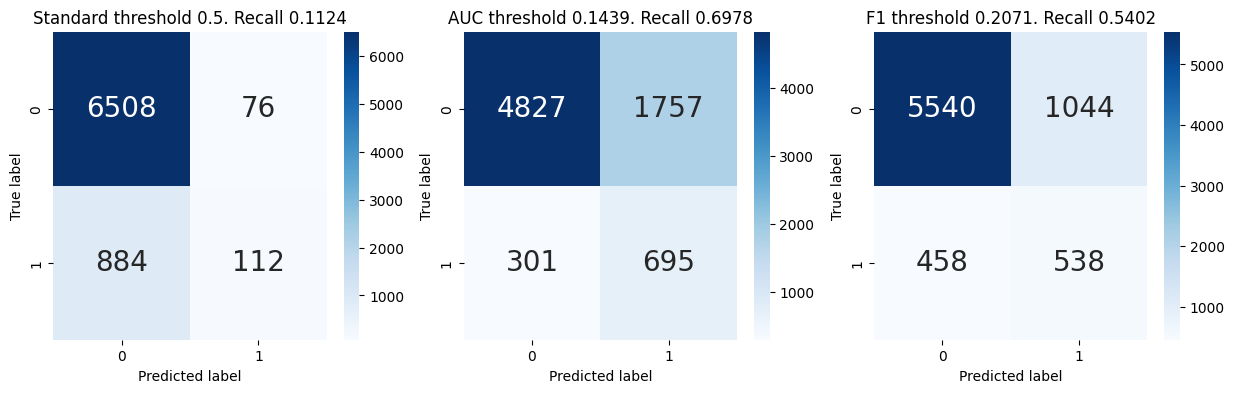

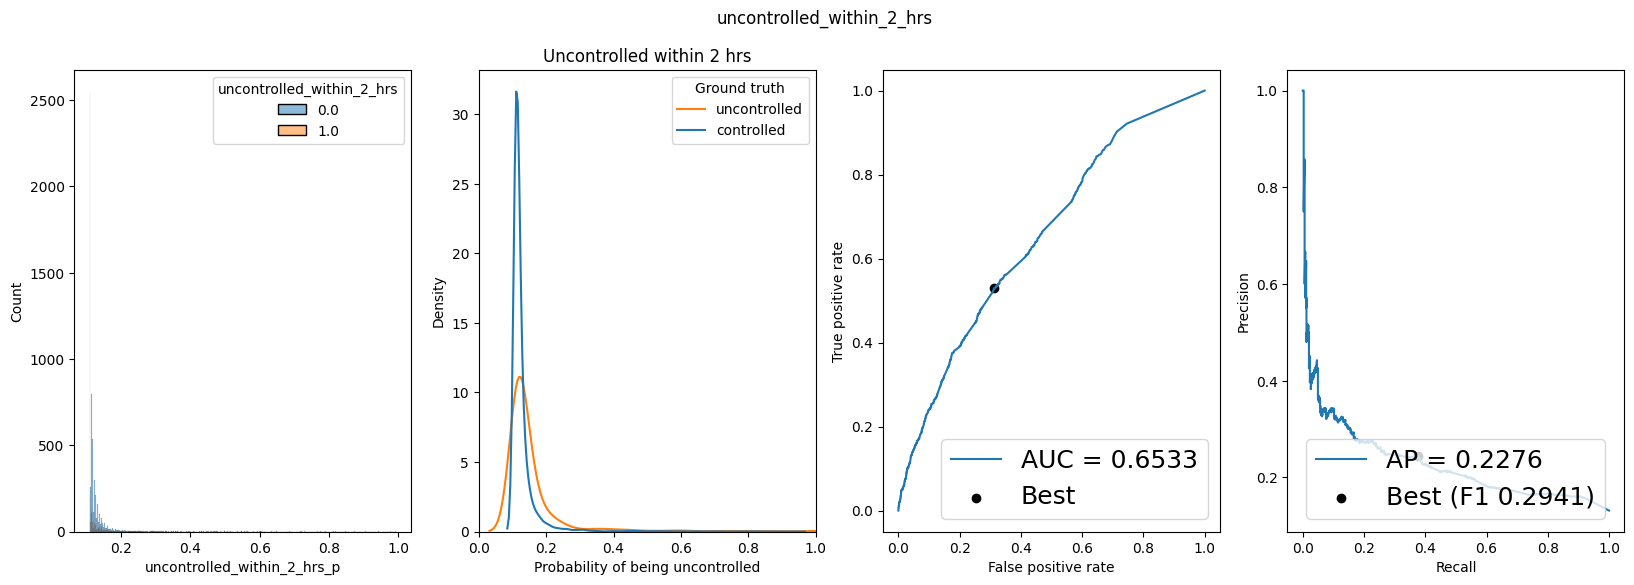

Model forest 
Fraction of data used in training: 1.0
Num rows in train:  3812 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.388758
         Iterations 7


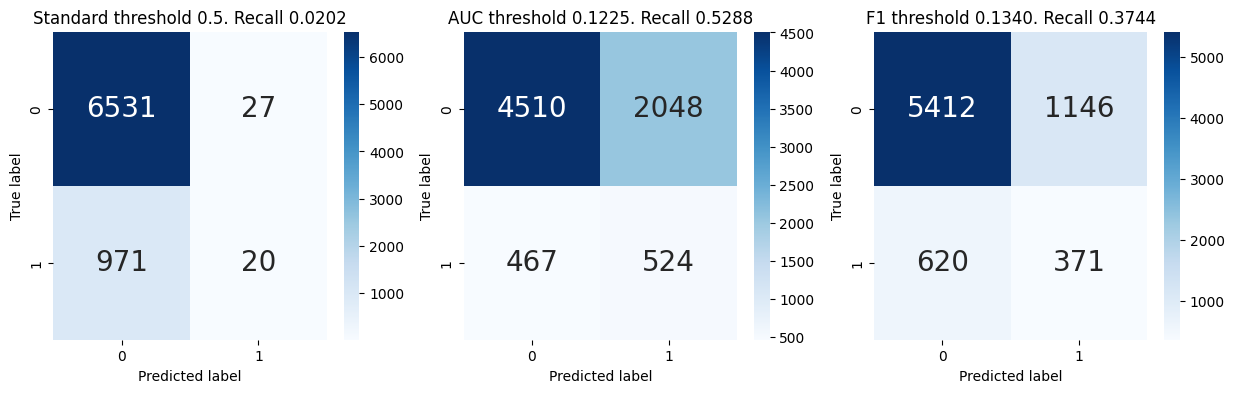

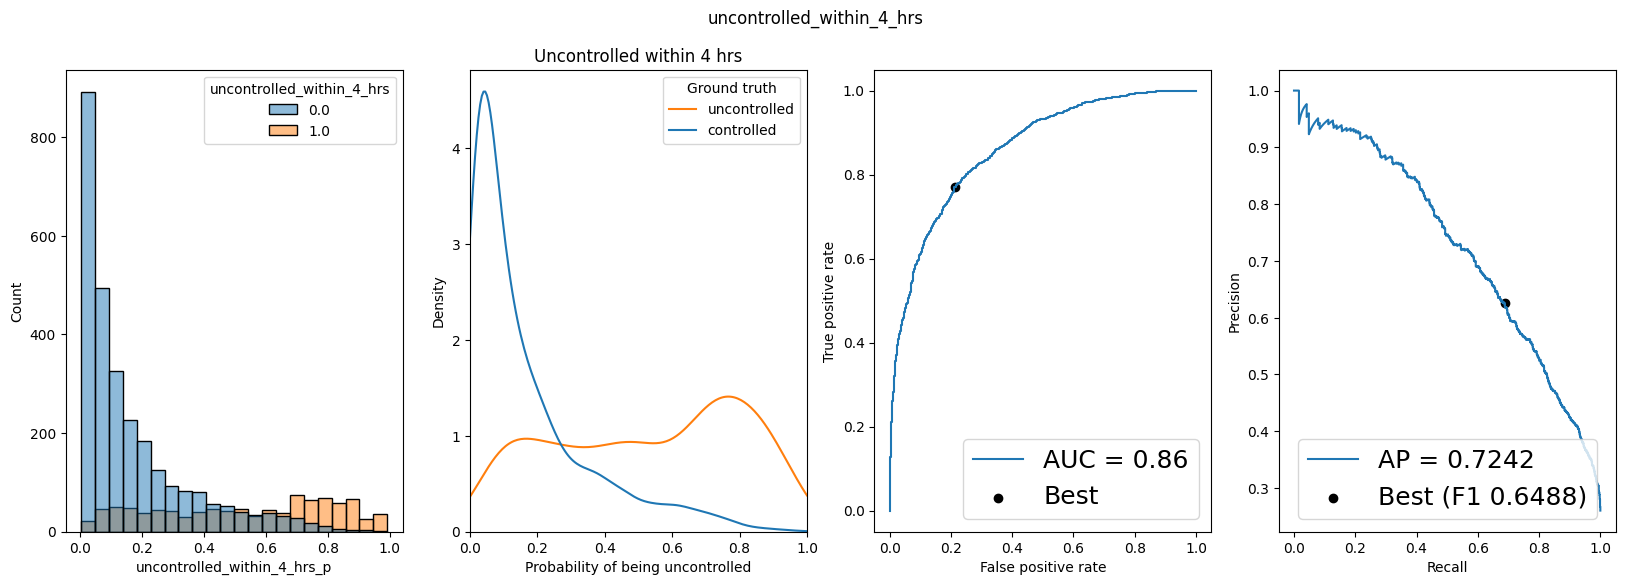

Model forest_fdi 
Fraction of data used in training: 1.0
Num rows in train:  3812 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.571891
         Iterations 5


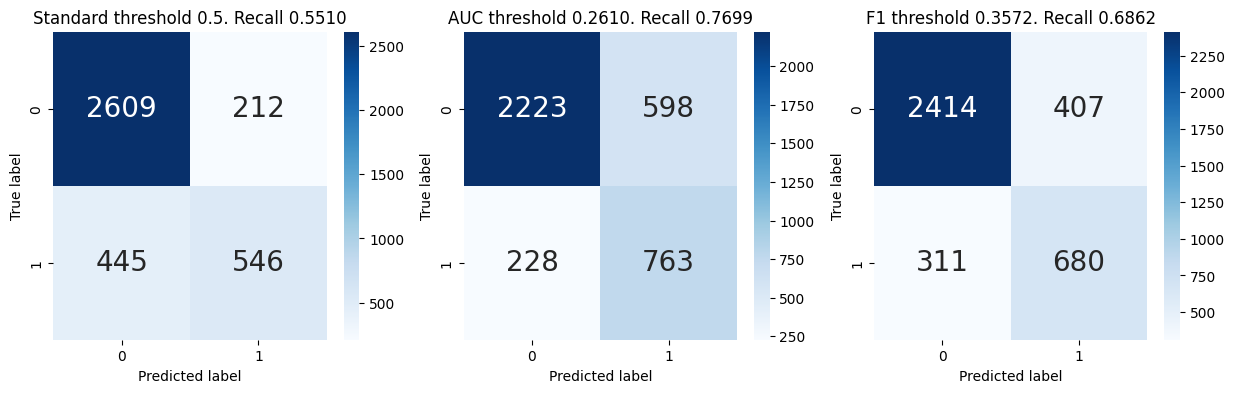

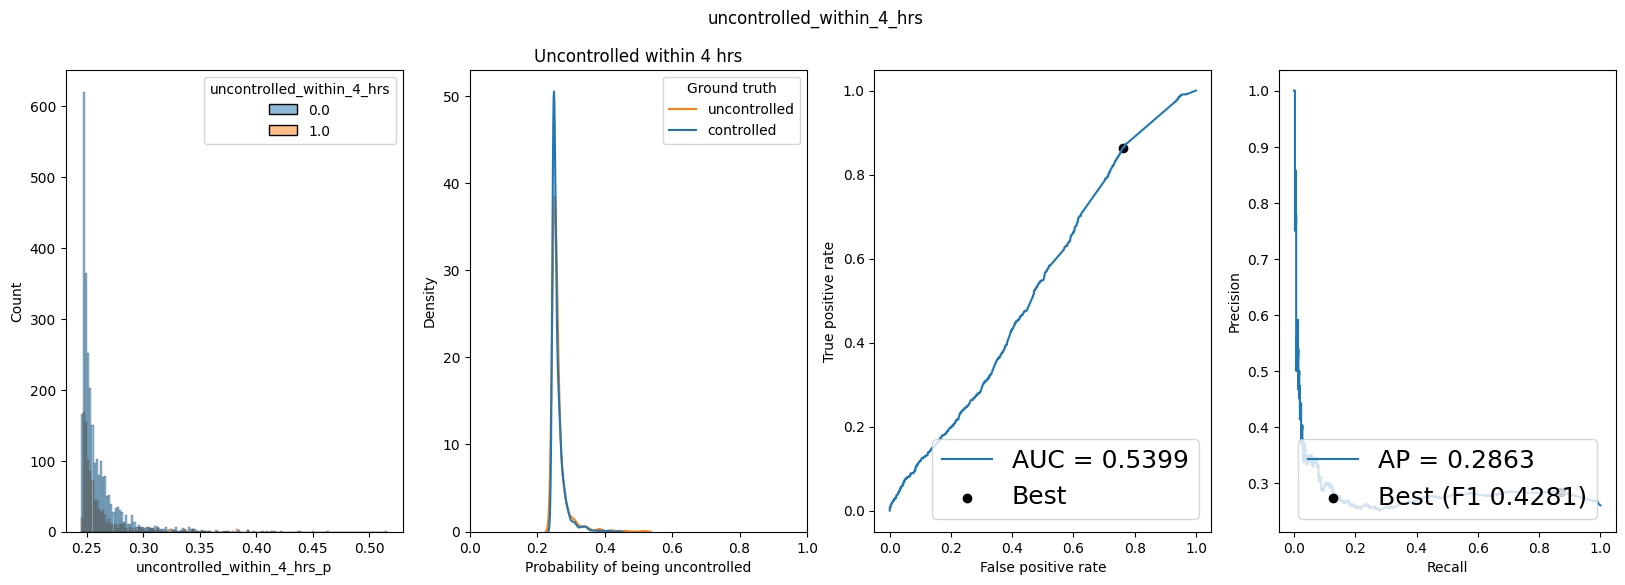

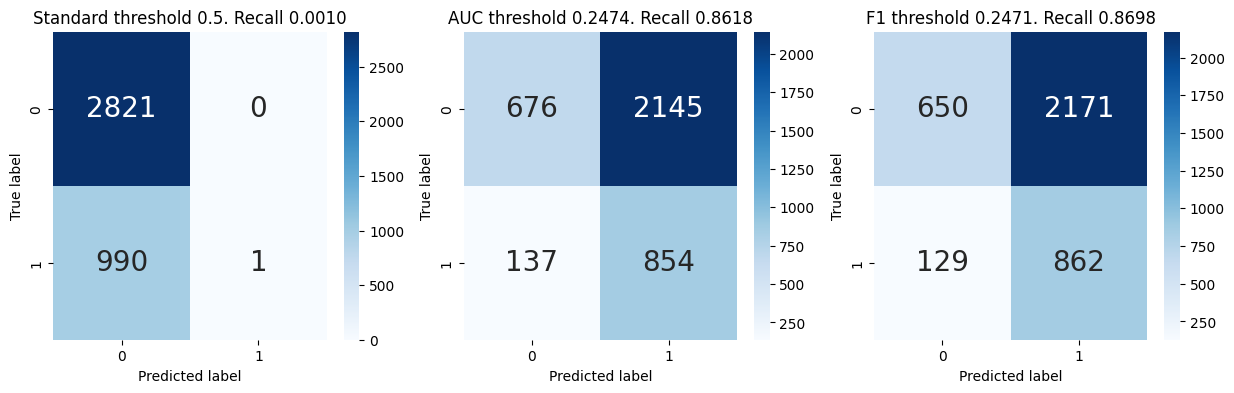

In [0]:
# Build all the models and store the output in the dictionary.
for model in models.keys():
    print('Model {} '.format(model))
    models[model]['fit'] = fit_logistic_regression(
        models[model]['incidents'],
        models[model]['outcome'],
        model_features=models[model]['model_features'],
        transform=models[model]['transforms']
    )
    get_model_diagnostics(
        rslt = models[model]['fit'][0],
        incidents_train = models[model]['fit'][1],
        incidents_test = models[model]['fit'][1],
        outcome = models[model]['outcome'],
        print_diagnostics=True, 
        print_confusion_matrix=True
        )

# Case studies


### Define days

In [0]:
# Make the test data just the days required (which are the rows with data in the date column).
for model in models.keys():
    models[model]['fit'] = list(models[model]['fit']) 
    incidents_test = models[model]['fit'][1].copy()
    incidents_test = incidents_test.dropna(subset='date')
    models[model]['fit'][2] = incidents_test


In [0]:
# Create a combined dataset
for model in ['grass', 'forest']:
    outcome = models[model]['outcome']
    test_data = models[model]['fit'][2].copy()
    test_data['outcome_p'] = test_data[outcome+'_p']
    test_data['outcome'] = test_data[outcome]
    
    if model == 'grass':
        test_data_combined = test_data.copy()
    else:
        test_data_combined = pd.concat([test_data_combined, test_data])


test_data_combined['primary_fuel_type'] = test_data_combined['primary_fuel_type'].cat.remove_categories(['shrub', 'noveg'])

### Plots for paper

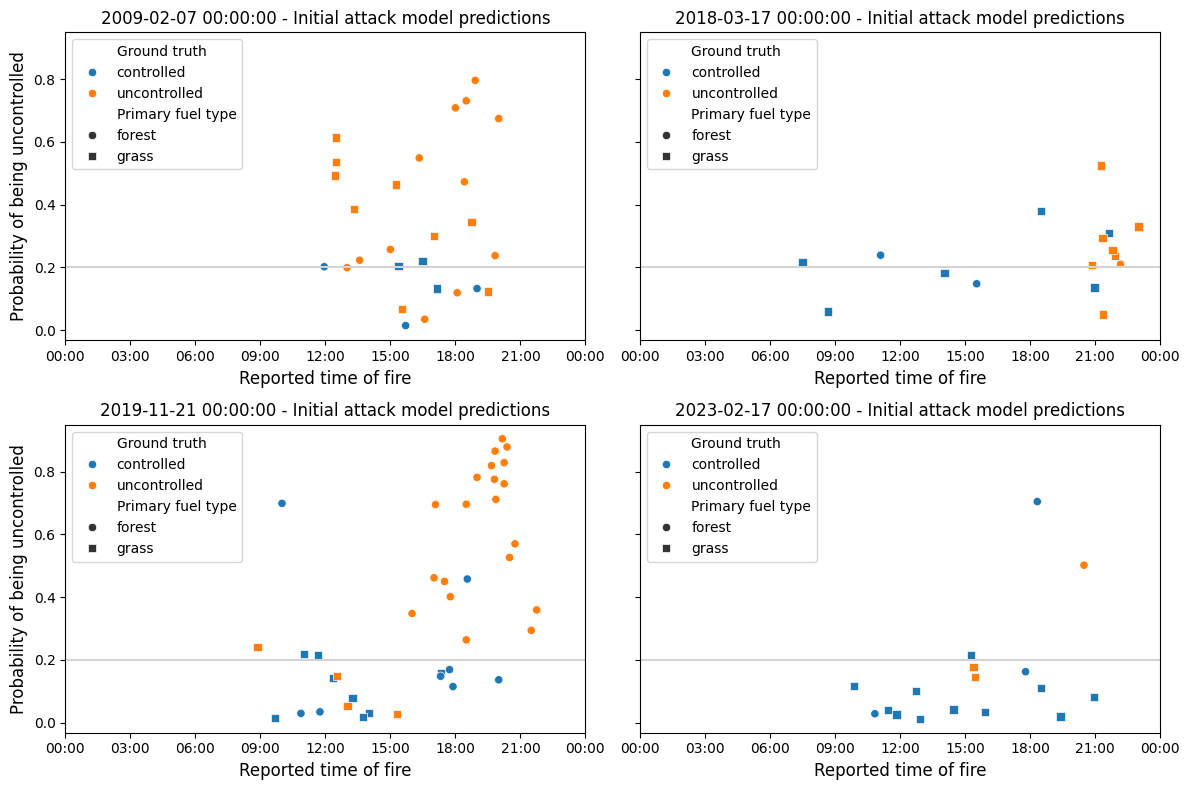

In [0]:
# Days for case studies
days = incidents["date"].dropna().unique()
# Set up plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True, sharey=True)
date_ix=0
for i in range(2):
    for j in range(2):
        day = days[date_ix]
        date_ix = date_ix + 1
        
        data=test_data_combined[test_data_combined['date']==day]
        data = (data
                .assign(**{'Ground truth': data['outcome'].map({1: 'uncontrolled', 0: 'controlled'}),
                           'Primary fuel type': data['primary_fuel_type']})
                .sort_values('outcome'))
        axs[i,j].xaxis.set_major_formatter(DateFormatter("%H:%M"))
        axs[i,j].title.set_text('{} - Initial attack model predictions'.format(day))
        axs[i,j].set_xlim(dt.combine(day, dt(1990,1,1,0,0,0).time()), dt.combine(day+timedelta(days=1), dt(1990,1,1,0,0,0).time()))
        sns.lineplot(x=[dt.combine(day, dt(1990,1,1,0,0,0).time()),dt.combine(day+timedelta(days=1), dt(1990,1,1,0,0,0).time())], y=[0.2,0.2], color='lightgrey', ax=axs[i,j])
        sns.scatterplot(data = data, x='reported_time', y='outcome_p', style='Primary fuel type', markers=['o', 's'], hue='Ground truth', ax=axs[i,j])
        axs[i,j].set_xlabel("Reported time of fire", fontsize=12)
        axs[i,j].set_ylabel("Probability of being uncontrolled", fontsize=12)